This demonstrates all the steps in my candidate selection before conducting visual inspection

In [1]:
import numpy as np
import splat
import wisps.data_analysis as wispd
from wisps.data_analysis import selection_criteria as sel_crt
import wispshapes
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import wisps

import matplotlib as mpl


import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
stars=wisps.Annotator.reformat_table(pd.read_hdf(wisps.COMBINED_PHOTO_SPECTRO_FILE, key='stars'))

In [3]:
stars[wisps.INDEX_NAMES]=(stars[wisps.INDEX_NAMES].applymap(float))

In [4]:
from astropy.table import Table
cands = Table.read(wisps.LIBRARIES+'/candidates.tex').to_pandas()

In [5]:
cands[wisps.INDEX_NAMES]=(stars[stars.grism_id.isin(cands['grism id'])])[wisps.INDEX_NAMES]

In [6]:
dt=stars[(stars.f_test< 0.4) &(stars.snr1>=3.)].reset_index(drop=True)

In [7]:
#(wisps.datasets['schneider'])[wisps.INDEX_NAMES]

In [8]:
gbhio=sel_crt.save_criteria(conts=dt)

  0%|          | 0/45 [00:00<?, ?it/s]

(2537, 26) (24, 26)


100%|██████████| 45/45 [00:24<00:00,  1.86it/s]


In [9]:
crts=sel_crt.crts_from_file()

In [10]:
contamns=pd.DataFrame([ x.contamination for x in crts.values()])
compls=pd.DataFrame([ x.completeness for x in crts.values()])

In [11]:
contamns.index=[x for x in crts.keys()]
compls.index=[x for x in crts.keys()]

In [12]:
contamns.style.apply(lambda x: ["background-color: #7FDBFF" 
                          if (i >= 0 and (v < 0.2 
                                          and v > 0. )) 
                          else "" for i, v in enumerate(x)], axis = 1)

,L0-L5,L5-T0,M7-L0,T0-T5,T5-T9,subdwarfs,trash,Y dwarfs
H_2O-1/J-Cont H_2O-2/H_2O-1,0.0746195,0.210727,0.15243,0.0555965,0.00012273,0.181271,0.307683,0.00159548
H_2O-1/J-Cont H-cont/H_2O-1,0.0893471,0.208886,0.151816,0.194772,0.0147275,0.250859,0.308542,0.0137457
H_2O-1/J-Cont CH_4/H_2O-1,0.0857879,0.209008,0.144944,0.145925,0.000859107,0.239691,0.291851,0.00662739
H_2O-1/J-Cont H_2O-2/J-Cont,0.0860334,0.199313,0.146048,0.0538783,0.00012273,0.233554,0.32241,0.000859107
H_2O-1/J-Cont H-cont/J-Cont,0.0661512,0.203608,0.140893,0.14163,0.00220913,0.208272,0.283505,0.00785469
H_2O-1/J-Cont CH_4/J-Cont,0.0666421,0.203731,0.134757,0.187653,0.00171821,0.171821,0.273073,0.00110457
H_2O-1/J-Cont H-cont/H_2O-2,0.0909091,0.129413,0.123139,0.247017,0.0169763,0.314799,0.298438,0.014762
H_2O-1/J-Cont CH_4/H_2O-2,0.0810678,0.0958297,0.131381,0.186001,0.0169763,0.257227,0.273834,0.014762
H_2O-1/J-Cont CH_4/H-Cont,0.0447872,0.0720543,0.100062,0.165207,0.00111043,0.124244,0.156817,0.000123381
H_2O-2/H_2O-1 H-cont/H_2O-1,0.19109,0.84217,0.360579,0.0547374,0.0932744,0.404516,0.363648,0.978522


In [13]:
#compls.style.apply(lambda x: ["background-color: #7FDBFF" 
#                          if (i >= 0 and (v >.95 )) 
#                          else "" for i, v in enumerate(x)], axis = 1)

In [14]:
stars[wisps.INDEX_NAMES].shape

(110930, 10)

In [15]:
(stars[wisps.INDEX_NAMES].dropna()).shape

(97448, 10)

In [16]:
#%%capture
#for c in crts.values(): c.plot(save=True)

In [17]:
to_use={'H_2O-1/J-Cont H_2O-2/H_2O-1':'L0-L5',
        'H_2O-1/J-Cont CH_4/H-Cont':'L5-T0' ,
        'H_2O-1/J-Cont CH_4/H_2O-1':'M7-L0',
        'H_2O-2/J-Cont CH_4/H-Cont': 'T0-T5',
        'H-cont/H_2O-1 CH_4/J-Cont': 'T5-T9',
        'CH_4/H_2O-1 H_2O-2/J-Cont': 'Y dwarfs',
        'H_2O-1/J-Cont CH_4/J-Cont': 'subdwarfs'
       }
        

In [18]:
len(to_use)

7

In [19]:
def box_parameters(idx, spt_range):
    bs=idx.shapes
    b=[x for x in bs if x.shape_name==spt_range][0]
    print ('{}  {} m: {} b: {} s:{}, comp : {}, cont: {}'.format(spt_range, idx,  round(b.coeffs[0], 2), round(b.coeffs[1], 2), round(b.scatter, 2), round(idx.completeness[spt_range], 2),  round(idx.contamination[spt_range], 3)))

In [20]:
spex_df=wisps.Annotator.reformat_table(wisps.datasets['spex']).reset_index(drop=True)
manj=wisps.Annotator.reformat_table(wisps.datasets['manjavacas']).reset_index(drop=True)
schn=wisps.Annotator.reformat_table(wisps.datasets['schneider']).reset_index(drop=True)

In [21]:
#schn.spt

In [22]:
for c in crts.values(): c

In [23]:
subdwarfs=wisps.Annotator.reformat_table(c._subdwarfs).reset_index(drop=True)

In [24]:
cands=pd.read_hdf(wisps.OUTPUT_FILES+'/true_spectra_cands.hdf',key='with_indices')

In [25]:
cands_dff=wisps.Annotator.reformat_table(cands)

In [26]:
#cands_dff

In [27]:
import pickle
#save the random forest
output_file=wisps.OUTPUT_FILES+'/best_indices_to_use.pkl'
with open(output_file, 'wb') as file:
    pickle.dump(to_use,file)

In [28]:
#dt

In [29]:
fp={}

In [30]:
cands_dff=wisps.Annotator.reformat_table(cands)

In [31]:
cands_dff.drop_duplicates().shape

(268, 17)

In [32]:
cands_dff.grism_id=cands_dff.grism_id.apply(lambda x: x.lower())

In [33]:
stars.grism_id=stars.grism_id.apply(lambda x: x.lower())

In [34]:
cx=cands_dff[cands_dff.grism_id.isin(stars.grism_id)]

In [35]:
cy=stars[stars.grism_id.isin(cx.grism_id)]

In [36]:
idx=crts['H_2O-1/J-Cont H_2O-2/H_2O-1']

In [37]:
ydwarfs=(manj[manj['spt'].apply(wisps.make_spt_number)>38].append(schn)).reset_index(drop=True)

In [38]:
def plot_index_box(index_name, box_name, ax):
    
    #get the index and the box
    idx=crts[index_name]
    bx=[x for x in idx.shapes if x.shape_name==box_name][0]
    
    xkey=idx.xkey
    ykey=idx.ykey
    
    to_use_df=spex_df
    if box_name.lower()=='y dwarfs':
        to_use_df=ydwarfs
    if box_name.lower()=='subdwarfs':
        to_use_df=wisps.Annotator.reformat_table((crts[index_name])._subdwarfs)
        to_use_df['spt']=17
    
    spexs_slctd, spexs_bools=bx._select(np.array([to_use_df[xkey].values,to_use_df[ykey].values]))
    
    
    #ax.scatter(spex_df[xkey], spex_df[ykey], facecolors='#AAAAAA', s=10., alpha=0.1)
    ax.scatter(dt[xkey].apply(float).values, dt[ykey].apply(float).values, marker='o', s=10., facecolors='none',  alpha=0.1,edgecolors='#AAAAAA')
    
  
    cands_slctd, cands_bools=bx._select(np.array([cands_dff[xkey].values,cands_dff[ykey].values]))
   
    trash_slctd, trsh_bools=bx._select(np.array([dt[xkey].values, dt[ykey].values]))
    
    
    cands_in_that_class_bool=(cands_dff[ cands_bools]).spt.apply(lambda x: wisps.is_in_that_classification(x, box_name))
    
    spexs_slctd_in_that_class_bool= (to_use_df[ spexs_bools]).spt.apply(lambda x: wisps.is_in_that_classification(x, box_name))
    
    if box_name.lower()=='subdwarfs':
         spexs_slctd_in_that_class_bool=np.ones(len(spexs_slctd[0]), dtype=bool)
    
    
    
    
    cands_in_that_class=np.array([cands_slctd[0][cands_in_that_class_bool], cands_slctd[1][cands_in_that_class_bool]])
    spexs_slctd_in_that_class=np.array([spexs_slctd[0][spexs_slctd_in_that_class_bool], spexs_slctd[1][spexs_slctd_in_that_class_bool]])

    ax.scatter(spexs_slctd_in_that_class[0], spexs_slctd_in_that_class[1], facecolors='#0074D9',  label='SpeX', s=10.)
    
    ax.scatter(cands_dff[xkey], cands_dff[ykey], marker='x', facecolors='#111111', s=10.)
    
    
    ax.scatter( cands_in_that_class[0],    cands_in_that_class[1], marker='x', facecolors='#FF851B', s=10, edgecolors='#2ECC40', label='candidates')
    
    
    bx.color='#2ECC40'
    bx.alpha=.1
    bx.plot(ax=ax, only_shape=True, highlight=False)
    
    
    ax.set_xlabel(r'$'+str(idx.name.split(' ')[0])+'$', fontsize=18)
    ax.set_ylabel(r'$'+str(idx.name.split(' ')[1])+'$', fontsize=18)
    
    ax.set_title(box_name, fontsize=18)
    
    xbuffer=np.nanstd(spexs_slctd)
    
    ax.set_xlim([ bx.xrange[0]-0.2*abs(np.ptp(bx.xrange)), bx.xrange[1]+0.2*abs(np.ptp(bx.xrange))])
    ax.set_ylim([ bx.yrange[0]-0.2*abs(np.ptp(bx.yrange)), bx.yrange[1]+0.2*abs(np.ptp(bx.yrange))])
    
    ax.minorticks_on()
    
    print (trash_slctd.shape[1],  cands_slctd.shape[1], box_name)
    if (trash_slctd.shape[1])==0:
        fprate=0.0
    else:
        fprate=(trash_slctd.shape[1]- cands_slctd.shape[1])/trash_slctd.shape[1]
        if box_name.lower()=='subdwarfs':
                fprate=1.
    
    fp[box_name]=  fprate

    

    
    return {str(box_name): bx}
    
    

In [39]:
to_use

{'H_2O-1/J-Cont H_2O-2/H_2O-1': 'L0-L5',
 'H_2O-1/J-Cont CH_4/H-Cont': 'L5-T0',
 'H_2O-1/J-Cont CH_4/H_2O-1': 'M7-L0',
 'H_2O-2/J-Cont CH_4/H-Cont': 'T0-T5',
 'H-cont/H_2O-1 CH_4/J-Cont': 'T5-T9',
 'CH_4/H_2O-1 H_2O-2/J-Cont': 'Y dwarfs',
 'H_2O-1/J-Cont CH_4/J-Cont': 'subdwarfs'}

608 47 L0-L5
584 31 L5-T0
1181 181 M7-L0
379 20 T0-T5
7 2 T5-T9
495 6 Y dwarfs
1400 132 subdwarfs


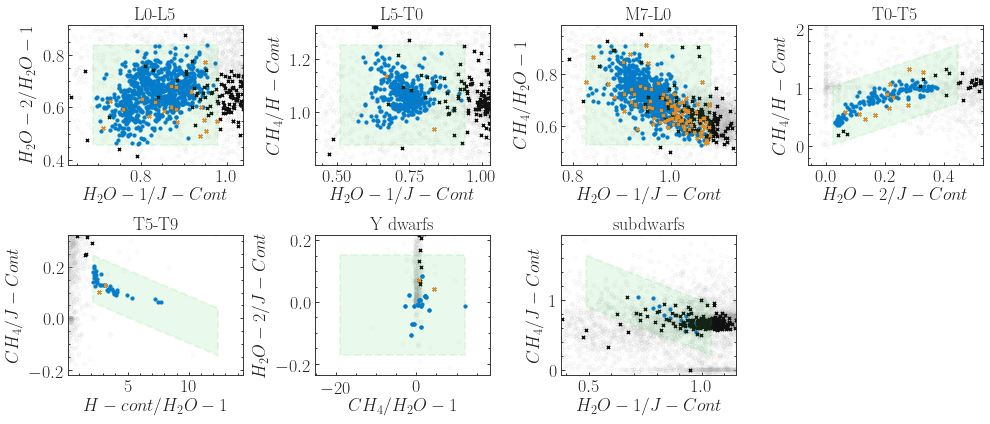

In [40]:
fig, ax=plt.subplots(nrows=2, ncols=4, figsize=(14, 6))

bxs=[]
for idx, k in enumerate(to_use.keys()):
    b=plot_index_box( k, to_use[k], np.concatenate(ax)[idx])
    bxs.append(b)
plt.tight_layout()
fig.delaxes(np.concatenate(ax)[-1])
#fig.delaxes(np.concatenate(ax)[-2])
plt.savefig(wisps.OUTPUT_FIGURES+'/index_index_plots.jpeg')

In [41]:
fp

{'L0-L5': 0.9226973684210527,
 'L5-T0': 0.946917808219178,
 'M7-L0': 0.8467400508044031,
 'T0-T5': 0.9472295514511874,
 'T5-T9': 0.7142857142857143,
 'Y dwarfs': 0.9878787878787879,
 'subdwarfs': 1.0}

In [42]:
bx_dict={}
for b in bxs:
    bx_dict.update(b)

In [43]:
#invert to use
inv_to_use = {v: k for k, v in to_use.items()}

In [44]:
inv_to_use

{'L0-L5': 'H_2O-1/J-Cont H_2O-2/H_2O-1',
 'L5-T0': 'H_2O-1/J-Cont CH_4/H-Cont',
 'M7-L0': 'H_2O-1/J-Cont CH_4/H_2O-1',
 'T0-T5': 'H_2O-2/J-Cont CH_4/H-Cont',
 'T5-T9': 'H-cont/H_2O-1 CH_4/J-Cont',
 'Y dwarfs': 'CH_4/H_2O-1 H_2O-2/J-Cont',
 'subdwarfs': 'H_2O-1/J-Cont CH_4/J-Cont'}

In [45]:
from tqdm import tqdm

In [46]:
ncandidates=[]
for spt_range in tqdm(bx_dict.keys()):
    idx_name=inv_to_use[spt_range]
    idx=crts[idx_name]
    s, bools=(bx_dict[spt_range])._select(np.array([dt[idx.xkey].values, dt[idx.ykey].values]))
    ncandidates.append(dt[bools])

100%|██████████| 7/7 [00:00<00:00, 21.27it/s]


In [47]:
len(pd.concat(ncandidates).drop_duplicates())

2910

In [48]:
pd.concat(ncandidates).drop_duplicates().to_pickle(wisps.OUTPUT_FILES+'/selected_by_indices.pkl')

In [49]:
def round_tuple(tpl, n=2):
    return round(tpl[0], n), round(tpl[1],n)

In [50]:
to_use.keys()

dict_keys(['H_2O-1/J-Cont H_2O-2/H_2O-1', 'H_2O-1/J-Cont CH_4/H-Cont', 'H_2O-1/J-Cont CH_4/H_2O-1', 'H_2O-2/J-Cont CH_4/H-Cont', 'H-cont/H_2O-1 CH_4/J-Cont', 'CH_4/H_2O-1 H_2O-2/J-Cont', 'H_2O-1/J-Cont CH_4/J-Cont'])

In [51]:
good_indices=[c for c in crts.values() if c.name in to_use.keys() ]

In [52]:
for idx, k in zip(good_indices, to_use.keys()):
    spt_range=to_use[k]
    bs=idx.shapes
    
    bx=[x for x in bs if x.shape_name==spt_range][0]
    print (" {} & {} &  {} & {} & {} & {} & {} & {} & {}  & {} \\\ ".format(spt_range,idx.xkey, idx.ykey, 
                                                                           round_tuple(bx.vertices[0]), round_tuple(bx.vertices[1])
                                                                           , round_tuple(bx.vertices[2]), round_tuple(bx.vertices[3]),
                                                                          round(idx.completeness[spt_range], 2), 
                                                                            round(idx.contamination[spt_range], 3), 
                                                                           round(fp[spt_range], 2)))
    

 L0-L5 & H_2O-1/J-Cont &  H_2O-2/H_2O-1 & (0.69, 0.84) & (0.98, 0.84) & (0.98, 0.46) & (0.69, 0.46) & 0.97 & 0.075  & 0.92 \\ 
 L5-T0 & H_2O-1/J-Cont &  CH_4/H_2O-1 & (0.51, 7.21) & (0.94, 7.21) & (0.94, -4.5) & (0.51, -4.5) & 0.98 & 0.209  & 0.95 \\ 
 M7-L0 & H_2O-1/J-Cont &  CH_4/J-Cont & (0.83, 0.83) & (1.08, 0.83) & (1.08, 0.54) & (0.83, 0.54) & 0.97 & 0.135  & 0.85 \\ 
 T0-T5 & H_2O-1/J-Cont &  CH_4/H-Cont & (0.23, 0.96) & (0.93, 1.74) & (0.93, 0.75) & (0.23, -0.04) & 0.97 & 0.165  & 0.95 \\ 
 T5-T9 & H-cont/H_2O-1 &  CH_4/J-Cont & (2.16, 0.24) & (12.39, 0.04) & (12.39, -0.14) & (2.16, 0.06) & 0.95 & 0.001  & 0.71 \\ 
 Y dwarfs & CH_4/H_2O-1 &  H_2O-2/J-Cont & (-19.18, 0.15) & (12.03, 0.15) & (12.03, -0.17) & (-19.18, -0.17) & 0.88 & 0.061  & 0.99 \\ 
 subdwarfs & H_2O-2/J-Cont &  CH_4/H-Cont & (0.18, 1.17) & (0.75, 1.17) & (0.75, 0.86) & (0.18, 0.85) & 0.89 & 0.163  & 1.0 \\ 


In [53]:
#for idx in np.arange(0, 45, 8):
#    ids=range(idx, idx + 8)
#    print (j.format(ids[0], ids[1], ids[2] , ids[3], ids[4], ids[5], ids[6], ids[7]).replace("<", "{").replace(">", "}"))


In [54]:
all_stuff=pd.read_hdf(wisps.COMBINED_PHOTO_SPECTRO_FILE, key='all_phot_spec_data')

In [55]:
len(all_stuff)

271915

In [56]:
len(stars)/len(all_stuff)

0.407958369343361

In [57]:
stars_with_snr= stars[(stars.snr1>=3.)]

In [58]:
len(stars_with_snr)/len(stars), len(stars_with_snr)/len(all_stuff)

(0.3878391778599117, 0.1582222385671993)

In [59]:
stars_with_ftest=(stars[(stars.f_test< 0.4) &(stars.snr1>=3.)])

In [60]:
len(stars_with_ftest), len(stars_with_ftest)/len(stars_with_snr), len(stars_with_ftest)/len(stars),  len(stars_with_ftest)/len(all_stuff)

(8148, 0.1893870720312391, 0.07345172631389164, 0.029965246492470073)

In [61]:
8000/200000

0.04

In [62]:
len(stars)

110930

In [63]:
43023/110930

0.3878391778599117